# Age caputering using voice
Dataset: https://www.kaggle.com/datasets/ogechukwu/voice?select=BVCvoicereadme.txt <br />
Author: Abdelrahman Lotfy <br />
Linkedin: https://www.linkedin.com/in/abdelrahman-mahmoud-9720221a7/

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d ogechukwu/voice

!unzip /content/voice.zip

Saving kaggle.json to kaggle.json
 98% 790M/802M [00:08<00:00, 119MB/s] 
100% 802M/802M [00:09<00:00, 93.1MB/s]
Archive:  /content/voice.zip
  inflating: BVC_Voice_Bio_Public.xlsx  
  inflating: BVCvoicereadme.txt      
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VE1.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VE2.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VE3.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VE4.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VE5.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VV1.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VV2.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VV3.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VV4.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4001_VV5.wav  
  inflating: S_02_voice/S_02/multiple_sentences/S_02_4008_VE1.wav  
  inflating: S_02_voice/S_02/mul

# Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import os

import librosa
import librosa.display
import IPython.display as ipd
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_splitr


from keras.callbacks import ReduceLROnPlateau
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Reading audio files

In [ ]:
def read_audio_files(directory):
    audio_list = []

    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            audio_list.append(os.path.join(dirname, filename))

    return audio_list

In [ ]:
audio_list = read_audio_files('multiple_sentences/multiple_sentences')

In [ ]:
audio_list

['multiple_sentences/multiple_sentences/S_01_4559_VV1.wav',
 'multiple_sentences/multiple_sentences/S_01_4120_VE5.wav',
 'multiple_sentences/multiple_sentences/S_01_4697_VV1.wav',
 'multiple_sentences/multiple_sentences/S_01_4653_VE1.wav',
 'multiple_sentences/multiple_sentences/S_01_4439_VV4.wav',
 'multiple_sentences/multiple_sentences/S_01_4079_VV2.wav',
 'multiple_sentences/multiple_sentences/S_01_4073_VE5.wav',
 'multiple_sentences/multiple_sentences/S_01_4351_VE4.wav',
 'multiple_sentences/multiple_sentences/S_01_4551_VV3.wav',
 'multiple_sentences/multiple_sentences/S_01_4128_VE5.wav',
 'multiple_sentences/multiple_sentences/S_01_4712_VE1.wav',
 'multiple_sentences/multiple_sentences/S_01_4465_VE2.wav',
 'multiple_sentences/multiple_sentences/S_01_4761_VE2.wav',
 'multiple_sentences/multiple_sentences/S_01_4139_VE5.wav',
 'multiple_sentences/multiple_sentences/S_01_4778_VE2.wav',
 'multiple_sentences/multiple_sentences/S_01_4128_VV2.wav',
 'multiple_sentences/multiple_sentences/

In [ ]:
def extract_number(string):
    parts = string.split('_')
    number = None

    for words in parts:
        if len(words) == 4:
            number = words
            break      
    return number

In [ ]:
#pip  install librosa

### Audio Sample

In [ ]:
ipd.Audio(audio_list[0]) #Sample of the audio files

### Note that for every audio ID there're 10 audi files, the first 5 are in English the other 5 are other languages <br />
-VE means voice in English <br />
-VV Means voice is in african language

## Feature extraction

In [158]:
def feature_extraction(data, sample_rate):
    #extract features from the audio
    
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

In [ ]:
pip install resampy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.7 MB/s eta 0:00:00


## Data Augmenation <br/>
### Adding data with noise, stretched waves, and pitch shifting

In [159]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

## Feature Extraction i.e original data and augmented data

In [160]:
def get_features(path):
    
    data, sample_rate = librosa.load(path, res_type = 'kaiser_fast')

    # without augmentation
    res1 = feature_extraction(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = feature_extraction(noise_data, sample_rate)
    result = np.vstack((result, res2))  # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feature_extraction(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3))  # stacking vertically
    
    return result

In [161]:
#features extraction from every audio
features = {}

for audio in audio_list:
    key = extract_number(audio)
    if key in features:
        features[key].append(get_features(audio))
    else:
        features[key] = [get_features(audio)]

In [163]:
features

{'4559': [array([[-3.40033600e+02,  8.71814346e+01,  1.95841179e+01,
           3.69152451e+01, -6.15875578e+00,  6.32308245e+00,
           3.36685514e+00,  1.52833004e+01, -1.69781189e+01,
           2.16132603e+01,  4.35790491e+00, -1.65908813e+00,
           3.55889410e-01,  5.57208252e+00, -9.87849998e+00,
           6.61974049e+00, -1.01105871e+01,  3.68221974e+00,
          -1.23156328e+01,  6.37822914e+00],
         [-2.37943653e+02,  3.83627111e+01,  1.99556791e+01,
           1.35030144e+01,  6.07481802e+00,  3.29906966e+00,
           4.86712275e+00,  2.60595447e+00,  1.02526295e+00,
           5.77958428e+00,  4.71185380e+00,  1.39100140e-01,
           2.17395491e-01, -3.89524907e-01, -2.25724399e+00,
          -1.96225781e+00, -2.59910422e+00, -3.44718310e+00,
          -2.69880865e+00, -6.53484353e-01],
         [-4.01838318e+02,  8.54291077e+01,  2.18747425e+01,
           2.98034878e+01, -5.48310137e+00,  4.50574923e+00,
           7.51213694e+00,  9.18289661e+00, -1.1

In [164]:
data = []

# Iterate over the dictionary items
for key, values in features.items():
    # Iterate over the list of feature values for each key
    for value in values:
        # Append a tuple containing the key and feature value to the data list
        data.append((key, value))

# Create a DataFrame from the data list
df = pd.DataFrame(data, columns=['Key', 'Feature']) 

In [165]:
df

,Key,Feature
0,4559,"[[-340.0335998535156, 87.18143463134766, 19.58..."
1,4559,"[[-316.44677734375, 86.70664978027344, 17.8448..."
2,4559,"[[-343.1009216308594, 75.98905944824219, 15.29..."
3,4559,"[[-361.5690002441406, 90.63594055175781, 31.83..."
4,4559,"[[-325.6768493652344, 83.57229614257812, 3.829..."
...,...,...
1773,4209,"[[-323.5313720703125, 126.05484008789062, 9.55..."
1774,4209,"[[-320.6705017089844, 156.4957733154297, 4.951..."
1775,4209,"[[-253.32862854003906, 135.29348754882812, -18..."
1776,4209,"[[-367.18603515625, 145.95901489257812, 15.499..."


In [166]:
dff = pd.read_csv('BVC_Voice_Bio_Public(1).csv')
dff

,New_ID,Sex,Age,Ethnicity,Unnamed: 4,Unnamed: 5
0,4001,'Male',19,'Igbo',NaN,336
1,4002,'Male',23,'Igbo',NaN,190
2,4003,'Female',18,'Ikwerre',NaN,NaN
3,4004,'Male',23,'Annang',NaN,% Actual subjects = 526
4,4005,'Female',17,'Igbo',NaN,% Male subjects = 336
...,...,...,...,...,...,...
555,4993,'Male',18,'Igede',NaN,NaN
556,4994,'Male',17,'Okirika',NaN,NaN
557,4995,'Male',22,'Igbo',NaN,NaN
558,4998,'Female',23,'Igbo',NaN,NaN


In [167]:
df = df.rename(columns={'Key': 'New_ID'})

## Merging the feature labels from the excel file in a dataframe

In [168]:
df

,New_ID,Feature
0,4559,"[[-340.0335998535156, 87.18143463134766, 19.58..."
1,4559,"[[-316.44677734375, 86.70664978027344, 17.8448..."
2,4559,"[[-343.1009216308594, 75.98905944824219, 15.29..."
3,4559,"[[-361.5690002441406, 90.63594055175781, 31.83..."
4,4559,"[[-325.6768493652344, 83.57229614257812, 3.829..."
...,...,...
1773,4209,"[[-323.5313720703125, 126.05484008789062, 9.55..."
1774,4209,"[[-320.6705017089844, 156.4957733154297, 4.951..."
1775,4209,"[[-253.32862854003906, 135.29348754882812, -18..."
1776,4209,"[[-367.18603515625, 145.95901489257812, 15.499..."


In [169]:
df['New_ID'] = df['New_ID'].astype(int)

In [170]:
merged_df = pd.merge(df, dff, on='New_ID')
merged_df

,New_ID,Feature,Sex,Age,Ethnicity,Unnamed: 4,Unnamed: 5
0,4559,"[[-340.0335998535156, 87.18143463134766, 19.58...",'Female',21,'Igbo',NaN,NaN
1,4559,"[[-316.44677734375, 86.70664978027344, 17.8448...",'Female',21,'Igbo',NaN,NaN
2,4559,"[[-343.1009216308594, 75.98905944824219, 15.29...",'Female',21,'Igbo',NaN,NaN
3,4559,"[[-361.5690002441406, 90.63594055175781, 31.83...",'Female',21,'Igbo',NaN,NaN
4,4559,"[[-325.6768493652344, 83.57229614257812, 3.829...",'Female',21,'Igbo',NaN,NaN
...,...,...,...,...,...,...,...
1773,4209,"[[-323.5313720703125, 126.05484008789062, 9.55...",'Male',18,'Igbo',NaN,NaN
1774,4209,"[[-320.6705017089844, 156.4957733154297, 4.951...",'Male',18,'Igbo',NaN,NaN
1775,4209,"[[-253.32862854003906, 135.29348754882812, -18...",'Male',18,'Igbo',NaN,NaN
1776,4209,"[[-367.18603515625, 145.95901489257812, 15.499...",'Male',18,'Igbo',NaN,NaN


In [171]:
cols_to_drop = ['Sex', 'Ethnicity', 'Unnamed: 4', 'Unnamed: 5']
merged_df.drop(cols_to_drop, inplace = True, axis = 1)


In [172]:
merged_df

,New_ID,Feature,Age
0,4559,"[[-340.0335998535156, 87.18143463134766, 19.58...",21
1,4559,"[[-316.44677734375, 86.70664978027344, 17.8448...",21
2,4559,"[[-343.1009216308594, 75.98905944824219, 15.29...",21
3,4559,"[[-361.5690002441406, 90.63594055175781, 31.83...",21
4,4559,"[[-325.6768493652344, 83.57229614257812, 3.829...",21
...,...,...,...
1773,4209,"[[-323.5313720703125, 126.05484008789062, 9.55...",18
1774,4209,"[[-320.6705017089844, 156.4957733154297, 4.951...",18
1775,4209,"[[-253.32862854003906, 135.29348754882812, -18...",18
1776,4209,"[[-367.18603515625, 145.95901489257812, 15.499...",18


In [174]:
feature_values = df['Feature'].values.tolist()
reshaped_features = np.reshape(feature_values, (1778, 60))
cdf = pd.concat([merged_df, pd.DataFrame(reshaped_features)], axis=1)

In [175]:
cdf

,New_ID,Feature,Age,0,1,2,3,4,5,6,...,50,51,52,53,54,55,56,57,58,59
0,4559,"[[-340.0335998535156, 87.18143463134766, 19.58...",21,-340.033600,87.181435,19.584118,36.915245,-6.158756,6.323082,3.366855,...,1.622432,-3.371615,4.352500,1.337700,-6.136284,2.276267,-8.891458,2.158128,-8.936779,7.752751
1,4559,"[[-316.44677734375, 86.70664978027344, 17.8448...",21,-316.446777,86.706650,17.844839,43.397091,-11.373741,5.839459,-1.337914,...,4.405469,-0.784355,-1.612289,2.883118,-9.704194,3.826505,-5.083100,5.593475,-13.596405,8.133452
2,4559,"[[-343.1009216308594, 75.98905944824219, 15.29...",21,-343.100922,75.989059,15.290206,49.344601,0.932434,5.015970,-6.574896,...,-4.728736,1.333881,5.733634,3.574364,-8.952753,3.234169,-10.428379,-1.065618,-17.042540,8.433074
3,4559,"[[-361.5690002441406, 90.63594055175781, 31.83...",21,-361.569000,90.635941,31.836338,35.830303,-9.107409,6.174457,4.314895,...,0.212146,-1.686211,10.404115,2.970722,-8.375077,3.606583,-9.071744,4.274077,-9.325386,4.750727
4,4559,"[[-325.6768493652344, 83.57229614257812, 3.829...",21,-325.676849,83.572296,3.829897,50.725567,1.750613,5.714041,-6.148643,...,-6.933056,0.345742,2.024250,1.495917,-6.187105,0.142147,-5.277564,2.889661,-8.165150,6.513834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1773,4209,"[[-323.5313720703125, 126.05484008789062, 9.55...",18,-323.531372,126.054840,9.557090,46.197094,5.528251,12.930729,-6.832590,...,-6.985533,2.584106,6.286902,0.770987,-1.721574,11.001561,-12.340887,7.758094,-1.971705,1.075416
1774,4209,"[[-320.6705017089844, 156.4957733154297, 4.951...",18,-320.670502,156.495773,4.951924,28.998289,6.084826,7.354878,-4.207283,...,-9.624327,5.596659,5.148415,-10.569311,-3.512221,14.167495,-12.918514,9.862942,-6.846985,3.909496
1775,4209,"[[-253.32862854003906, 135.29348754882812, -18...",18,-253.328629,135.293488,-18.401470,40.746140,1.674888,7.896039,-13.199593,...,-5.629018,2.559736,10.209964,-2.513043,1.212460,14.207981,-13.650156,3.852966,-5.907478,-1.636865
1776,4209,"[[-367.18603515625, 145.95901489257812, 15.499...",18,-367.186035,145.959015,15.499521,33.578087,5.458046,-1.798597,1.722124,...,-4.179851,7.887046,-1.874426,-3.046463,0.694584,8.467064,-9.562577,9.382884,-4.938970,3.787987


In [176]:
cdf.drop('Feature', inplace = True, axis = 1)


In [177]:
cdf.drop('New_ID', inplace = True, axis = 1)

In [178]:
cdf

,Age,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,21,-340.033600,87.181435,19.584118,36.915245,-6.158756,6.323082,3.366855,15.283300,-16.978119,...,1.622432,-3.371615,4.352500,1.337700,-6.136284,2.276267,-8.891458,2.158128,-8.936779,7.752751
1,21,-316.446777,86.706650,17.844839,43.397091,-11.373741,5.839459,-1.337914,13.333817,-18.784897,...,4.405469,-0.784355,-1.612289,2.883118,-9.704194,3.826505,-5.083100,5.593475,-13.596405,8.133452
2,21,-343.100922,75.989059,15.290206,49.344601,0.932434,5.015970,-6.574896,18.129808,-13.723123,...,-4.728736,1.333881,5.733634,3.574364,-8.952753,3.234169,-10.428379,-1.065618,-17.042540,8.433074
3,21,-361.569000,90.635941,31.836338,35.830303,-9.107409,6.174457,4.314895,22.022598,-23.001446,...,0.212146,-1.686211,10.404115,2.970722,-8.375077,3.606583,-9.071744,4.274077,-9.325386,4.750727
4,21,-325.676849,83.572296,3.829897,50.725567,1.750613,5.714041,-6.148643,8.328362,-16.056334,...,-6.933056,0.345742,2.024250,1.495917,-6.187105,0.142147,-5.277564,2.889661,-8.165150,6.513834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1773,18,-323.531372,126.054840,9.557090,46.197094,5.528251,12.930729,-6.832590,-3.931611,-0.421911,...,-6.985533,2.584106,6.286902,0.770987,-1.721574,11.001561,-12.340887,7.758094,-1.971705,1.075416
1774,18,-320.670502,156.495773,4.951924,28.998289,6.084826,7.354878,-4.207283,-0.172847,-8.097899,...,-9.624327,5.596659,5.148415,-10.569311,-3.512221,14.167495,-12.918514,9.862942,-6.846985,3.909496
1775,18,-253.328629,135.293488,-18.401470,40.746140,1.674888,7.896039,-13.199593,-2.651602,-6.299568,...,-5.629018,2.559736,10.209964,-2.513043,1.212460,14.207981,-13.650156,3.852966,-5.907478,-1.636865
1776,18,-367.186035,145.959015,15.499521,33.578087,5.458046,-1.798597,1.722124,7.422940,-8.234290,...,-4.179851,7.887046,-1.874426,-3.046463,0.694584,8.467064,-9.562577,9.382884,-4.938970,3.787987


## Preparing the features and labels for spliting

In [179]:
X = cdf
Y = cdf['Age']


In [180]:
X = X.drop('Age', axis = 1)

In [181]:
#from sklearn.preprocessing import StandardScaler, OneHotEncoder
# As this is a multiclass classification problem onehotencoding our Y.
#encoder = OneHotEncoder()
#Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [182]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True, test_size = 0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1422, 60), (1422, 14), (356, 60), (356, 14))

### Scaling the data by subtracting it from the mean/standard deviation for a better performance

In [183]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train) # x - mean/std
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1422, 60), (1422, 14), (356, 60), (356, 14))

### Reshaping the data for the model input

In [184]:
#making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1422, 60, 1), (1422, 14), (356, 60, 1), (356, 14))

In [185]:
x_train.shape[1]

60

# LSTM Model Construction

In [186]:
model = Sequential()

model.add(LSTM(256, input_shape=(x_train.shape[1], 1), return_sequences=True))
model.add(LSTM(128, activation = 'sigmoid', return_sequences=True))
model.add(LSTM(64, activation = 'linear'))

model.add(Dense(1, activation='linear')) # Update the number of units to 8

In [187]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Print the model summary
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 60, 256)           264192    
                                                                 
 lstm_35 (LSTM)              (None, 60, 128)           197120    
                                                                 
 lstm_36 (LSTM)              (None, 64)                49408     
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 510,785
Trainable params: 510,785
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [188]:
rlrp = ReduceLROnPlateau(monitor='loss', min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
23/23 [==============================] - 25s 623ms/step - loss: 0.1240 - val_loss: 0.0748 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - 13s 578ms/step - loss: 0.0686 - val_loss: 0.0665 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - 13s 567ms/step - loss: 0.0665 - val_loss: 0.0664 - lr: 0.0010
Epoch 4/50
23/23 [==============================] - 13s 560ms/step - loss: 0.0663 - val_loss: 0.0663 - lr: 0.0010
Epoch 5/50
23/23 [==============================] - 13s 575ms/step - loss: 0.0663 - val_loss: 0.0663 - lr: 0.0010
Epoch 6/50
23/23 [==============================] - 14s 579ms/step - loss: 0.0663 - val_loss: 0.0663 - lr: 0.0010
Epoch 7/50
23/23 [==============================] - 13s 557ms/step - loss: 0.0663 - val_loss: 0.0663 - lr: 0.0010
Epoch 8/50
23/23 [==============================] - 13s 571ms/step - loss: 0.0663 - val_loss: 0.0663 - lr: 0.0010
Epoch 9/50
23/23 [==============================] - 13s 573ms/step - loss: 0.0663 - val_

# Model performance and score

In [190]:
y_predict = model.predict(x_test)

12/12 [==============================] - 3s 102ms/step


In [148]:
def calculate_mse(predicted_values, actual_values):
    if len(predicted_values) != len(actual_values):
        raise ValueError("Number of predicted values does not match number of actual values.")
    
    squared_errors = [(p - a) ** 2 for p, a in zip(predicted_values, actual_values)]
    mse = sum(squared_errors) / len(predicted_values)
    
    return mse


In [149]:
mse = calculate_mse(y_predict, y_test)

In [150]:
mse[0]

0.021957798389352655

In [191]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)*100 , "%")

12/12 [==============================] - 1s 108ms/step - loss: 0.0663
Accuracy of our model on test data :  6.632653623819351 %


In [147]:
#from sklearn.metrics import r2_score
#score = r2_score(y_test, y_predict)
#print(score)

In [ ]:
mse = mean_squared_error(y_test, y_predict)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.061838551006011246


12/12 [==============================] - 0s 10ms/step - loss: 0.0618
Accuracy of our model on test data :  6.18385449051857 %


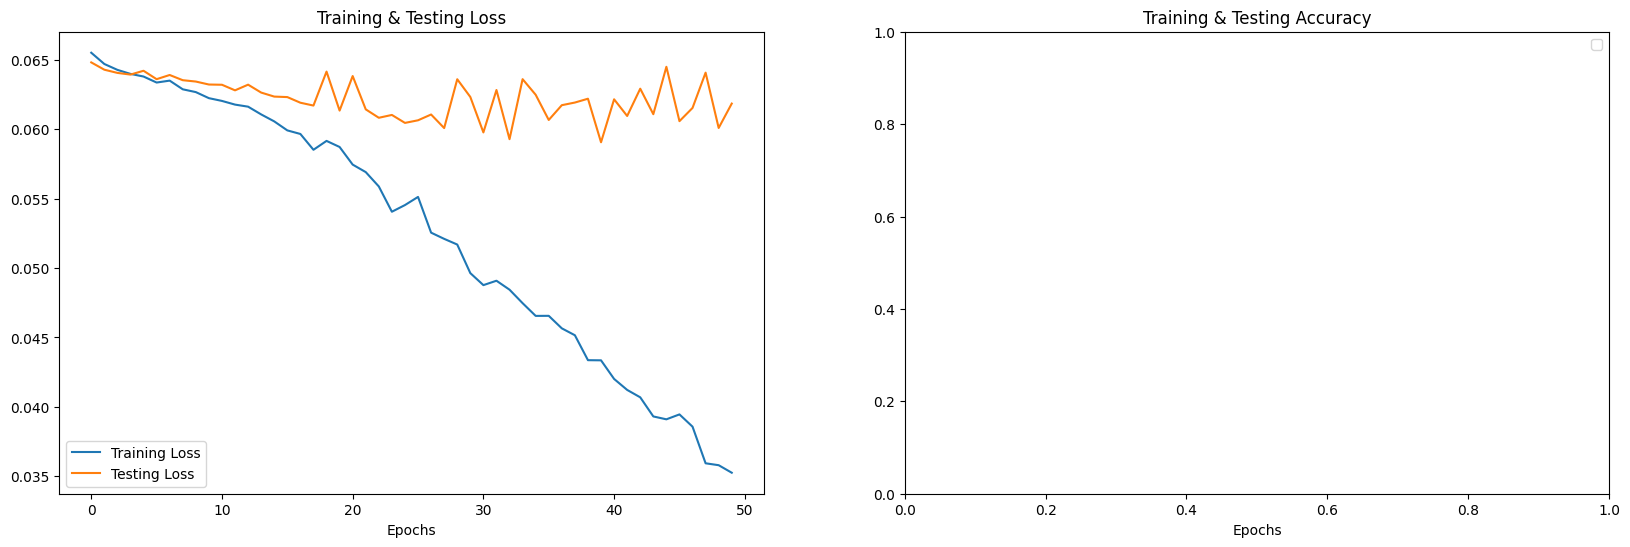

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)

train_loss = history.history['loss']

test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")



ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

## The model overfited as it has high variance. The model is better to be stopped at the 20 epochs